In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.visualization import *
from decode_fish.funcs.predict import predict

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

# Training (data taken from starfish MERFISH analysis notebook)

Load base config

In [1750]:
cfg = OmegaConf.load('../config/train.yaml')

Make dataset specific changes

In [1761]:
cfg.output.project = 'MERFISH_starfish'

# Path to the recording you want to train the network on. Can also use a * expression to load multiple tiffs (e.g. path/*.tif)
cfg.data_path.image_path = cfg.base_dir + '/datasets/CodFish/MERFISH/starfish_scaled/*.tiff'

# We initialize the PSF as a Gaussian with the given radii. Should be adjusted to get a rough visual fit between recording and simulation.
cfg.data_path.psf_path = None
cfg.PSF.psf_extent_zyx = [1,21,21]
cfg.PSF.gauss_radii = [1.,1.8,1.8]
cfg.model.is_2D = True

cfg.evaluation.crop_sl = 's_[:,:,1500:1650,150:300]'
cfg.evaluation.px_size_zyx =  [100,100,100]

# Average number of foci per simulated volume. If your data does not contain any foci set this to 0.
cfg.foci.n_foci_avg = 0
# Lower and upper limit of emitters simulated per focus
cfg.foci.n_mol_range: [5,30]

# Sets the intensity scale of the simulation. Should be adjusted to cover observed intensity values 

cfg.prob_generator.low = 0.0002
cfg.prob_generator.high = 0.03

# Set to 'disabled' if you do not have a wandb account.
cfg.output.wandb_mode = 'online'

cfg.model.f_maps = 64
cfg.training.bs = 30
cfg.noise.theta = float(3.)

cfg.roi_mask.percentile = 20
cfg.microscope.norm = 'none'
cfg.bg_estimation.smoothing.smoothing_filter_size = 4

cfg.intensity_dist.int_conc = 3.
cfg.intensity_dist.int_rate = 1.
cfg.intensity_dist.int_loc = 1.

cfg.run_name ='MERFISH_starfish_ch0_f5'
cfg.data_path.sm_fish_ch = 0
cfg.microscope.scale = 50
cfg.bg_estimation.fractal.persistence = 0.50
cfg.bg_estimation.fractal.scale = 50

# cfg.run_name ='MERFISH_starfish_ch1_f5'
# cfg.data_path.sm_fish_ch = 1
# cfg.microscope.scale = 30
# cfg.bg_estimation.fractal.persistence = 0.50
# cfg.bg_estimation.fractal.scale = 30

In [1762]:
OmegaConf.save(cfg, f'../config/experiment/{cfg.run_name}.yaml')
cfg.run_name

'MERFISH_starfish_ch0_f5'

We load the image and use a simple heuristic function to estimate the noise scale. Here we use the 99% lowest intensity values
to exlude the majority of the signal. Set the percentile value to obtain a range like below. If it is to high (e.g. 99.9 in this example) you will see a long tail with high intensities, if it is to low, e.g. 95 you will get something that looks like a truncated Gaussian.

0.6589882317069946


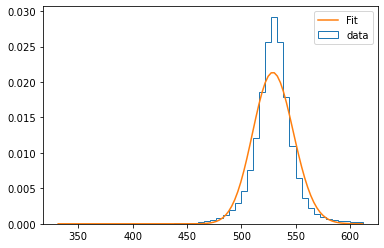

In [1745]:
img = load_tiff_image(sorted(glob.glob(cfg.data_path.image_path))[0])[cfg.data_path.sm_fish_ch][None]
bg_est = hydra.utils.instantiate(cfg.bg_estimation.smoothing, device='cpu')(img)
theta = estimate_noise_scale(img, bg_est, percentile=99)
print(theta)

In [1746]:
cfg.noise.theta = float(theta)

Here we plot maximum intensity projections of the whole volume and the sub volume given by evaluation.crop_sl.  
The localizations for this sub volume are tracked during training to evaluate progress. You should chose an interesting (e.g. dense) region.

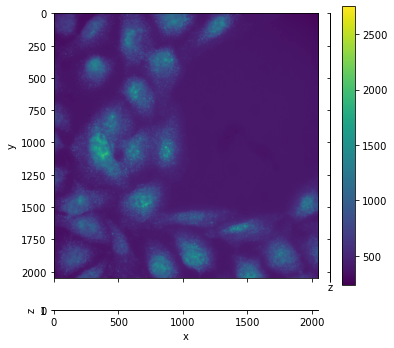

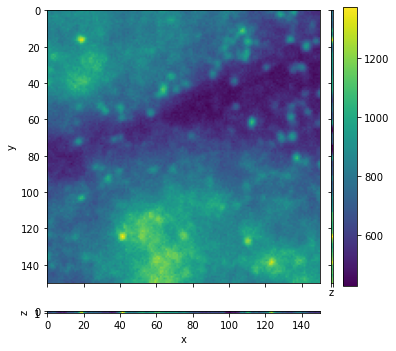

In [1747]:
_ = plot_3d_projections(img, size=5, proj_func=np.max)
sl = eval(cfg.evaluation.crop_sl,{'__builtins__': None},{'s_': np.s_})
_ = plot_3d_projections(img[sl[:]], size=5)

Create the dataloader which samples random subsets from the recorded volumes and generates simulated data that we use for training.  
For visualization purposes it is often better to not sample foci as they distort the colorscale.

In [1748]:
n_foci = cfg.foci.n_foci_avg
cfg.foci.n_foci_avg = 0
img_3d, decode_dl = get_dataloader(cfg)
psf, noise, micro = load_psf_noise_micro(cfg)
cfg.foci.n_foci_avg = n_foci

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
8 volumes


This function allows you to visually compare the recorded data and the simulations generated with the given config.  
For each sample we plot a slice from the input volume and from a simulated training volume as well as the estimated background.  
In the second row we compare maximum intensity projections.  

Adjust the microscope.scale and PSF.gauss_radii until you achieve a rough match in intensities and the PSF shape.  
You don't have to get this exactly right as these values get automatically fine tuned during training.
It is totally fine if average density of emitters in the simulations is higher than in the recordings.

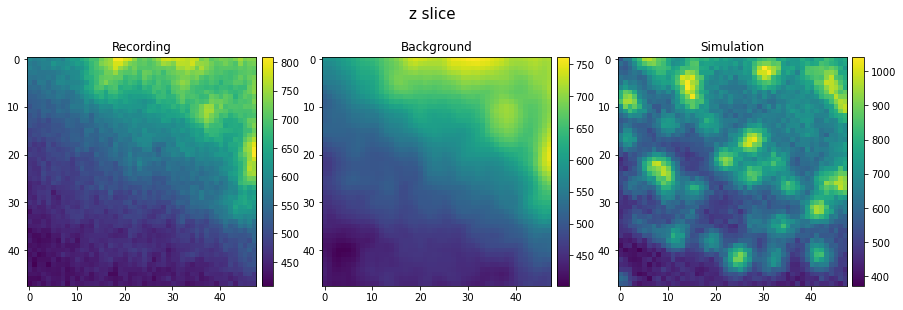

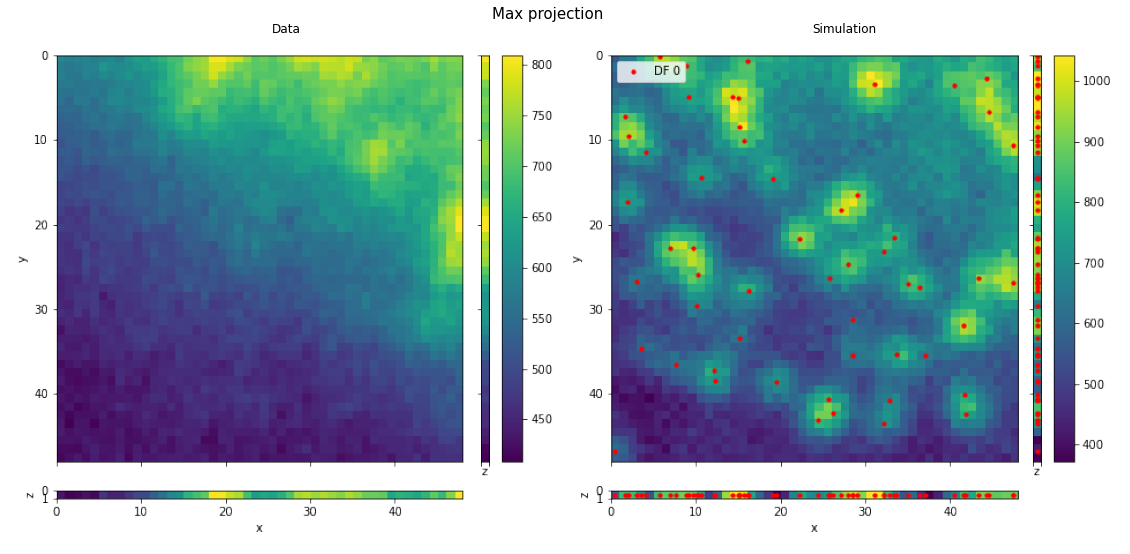

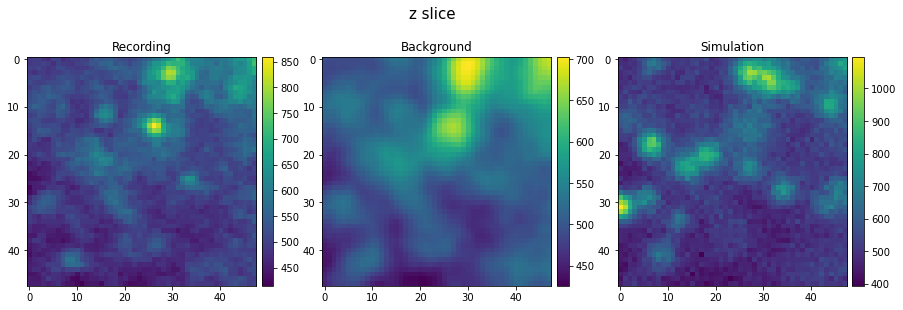

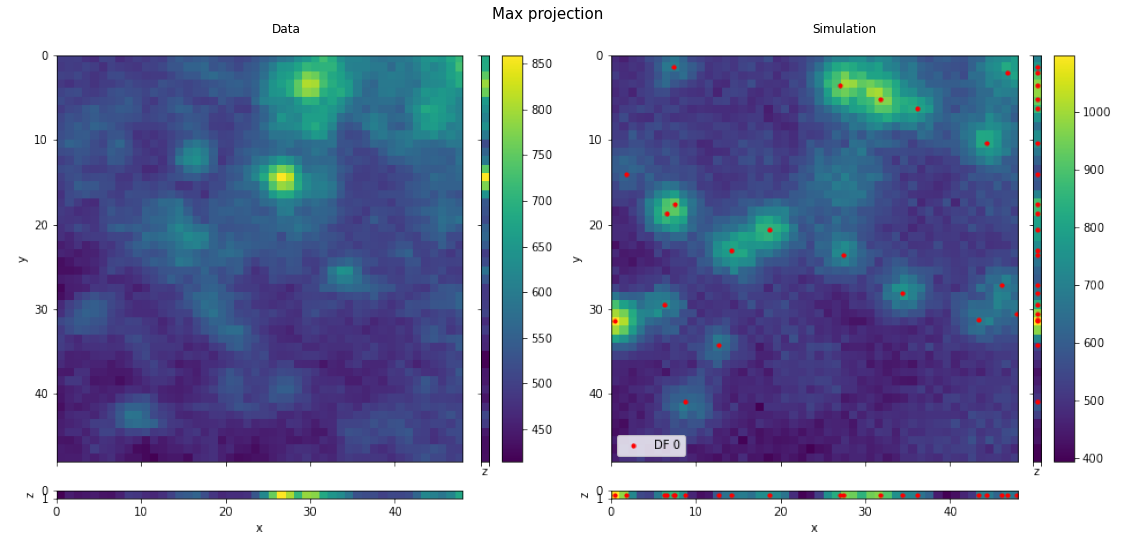

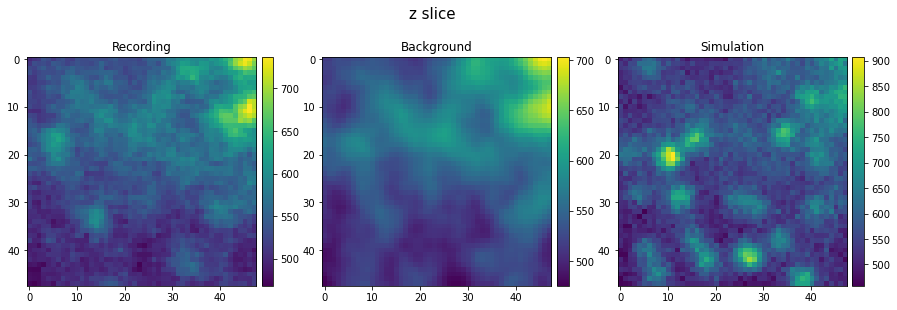

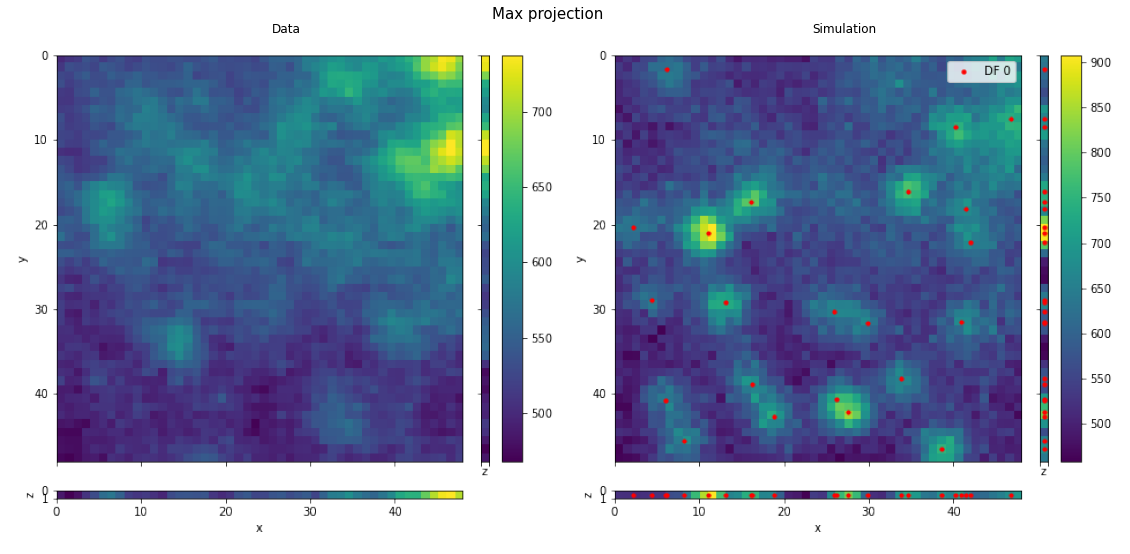

In [1749]:
get_simulation_statistics(decode_dl, micro, **cfg.intensity_dist, int_threshold=10, samples=3)

Store the config as an experiment

In [352]:
OmegaConf.save(cfg, f'../config/experiment/{cfg.run_name}.yaml')
cfg.run_name

'MERFISH_starfish_ch0_f3'

The config file is all you need to train your model. There is a couple of options.  
* You can load the config in the nbs/13_train.ipynb notebook and run all cells. This will continuously produce plots that let you track the training progress.  
* The recommended method is to execute the exeriment in your terminal: "python decode_fish/train.py +experiment=msp300_1"  If you enabled wandb tracking you will get a link for this run.
* You change parameters of your parameters in the command line. For example if you want to run training for more iterations you could execute:  
"python decode_fish/train.py +experiment=msp300_1 training.num_iters=50000 run_name=long_run"


Command to train a model on the gpu cluster

In [1710]:
home_dir = os.getenv("HOME")
f'bsub -gpu "num=1" -q gpu_any -o {home_dir}/logs/ofish.log -e {home_dir}/logs/efish.log {home_dir}/anaconda3/envs/decode_fish_dev/bin/python {home_dir}/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment={cfg.run_name}'

'bsub -gpu "num=1" -q gpu_any -o /groups/turaga/home/speisera/logs/ofish.log -e /groups/turaga/home/speisera/logs/efish.log /groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment=MERFISH_starfish_ch1_f4'

# Evaluation

In [1769]:
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//models/fishcod/MERFISH_starfish/nb_run/MERFISH_starfish_ch0_f2/train.yaml')
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_bg_1b/scale:0xsmoothing_filter_size:5/train.yaml')

In [ ]:

scale:0xsmoothing_filter_size:5


In [1770]:
# Load the model, post processing, imgages, dataloader
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)
psf_init = get_gaussian_psf(cfg.PSF.psf_extent_zyx,cfg.PSF.gauss_radii)
psf_init = cpu(psf_init.psf_volume[0])
psf_vol = cpu(micro.psf.psf_volume[0])

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
8 volumes


Plot mean projections of the PSF before and after optimizing it during training

(tensor(0., device='cuda:0', grad_fn=<DivBackward0>), tensor(10.0001, device='cuda:0', grad_fn=<DivBackward0>), tensor(10.0000, device='cuda:0', grad_fn=<DivBackward0>))


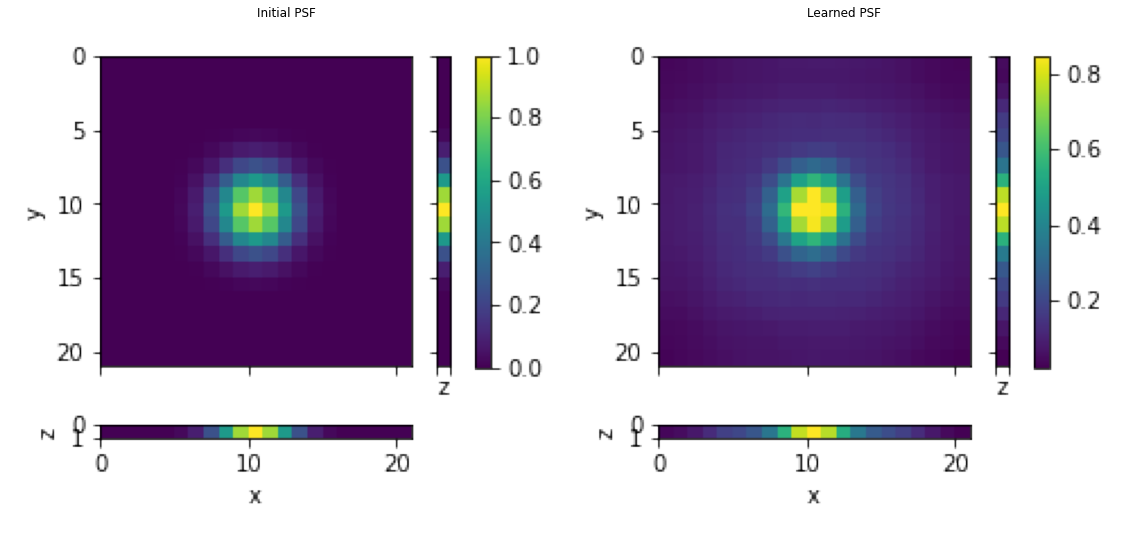

In [1771]:
print(micro.psf.get_com())
fig1,_ =plot_3d_projections(psf_init, proj_func=np.mean, size=3, display=False)
fig2,_ =plot_3d_projections(psf_vol, proj_func=np.mean, size=3, display=False)
_ = combine_figures([fig1,fig2],['Initial PSF','Learned PSF'], nrows=1, ncols=2, figsize=(20,10))

Sample random sub volumes and overlay them with predictions,  also shows the residuals between the input volume and the reconstruction from applying the microscope and PSF model to those predictions. Sometimes it looks like the network if missing obvious molecules. Often times this is because they are at the very edge of the volume. In that case they will be localized once you process the whole volume.

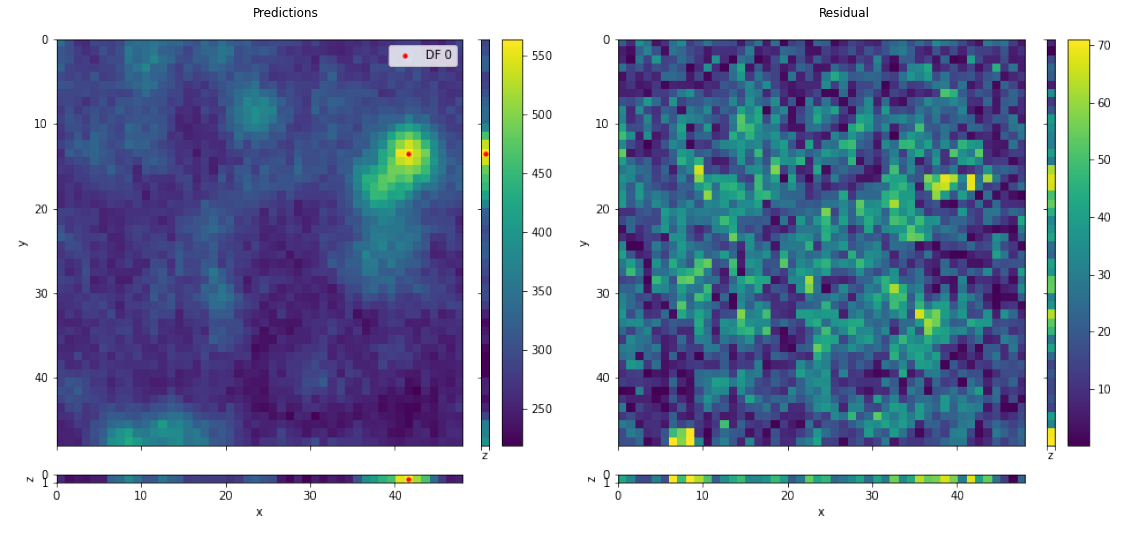

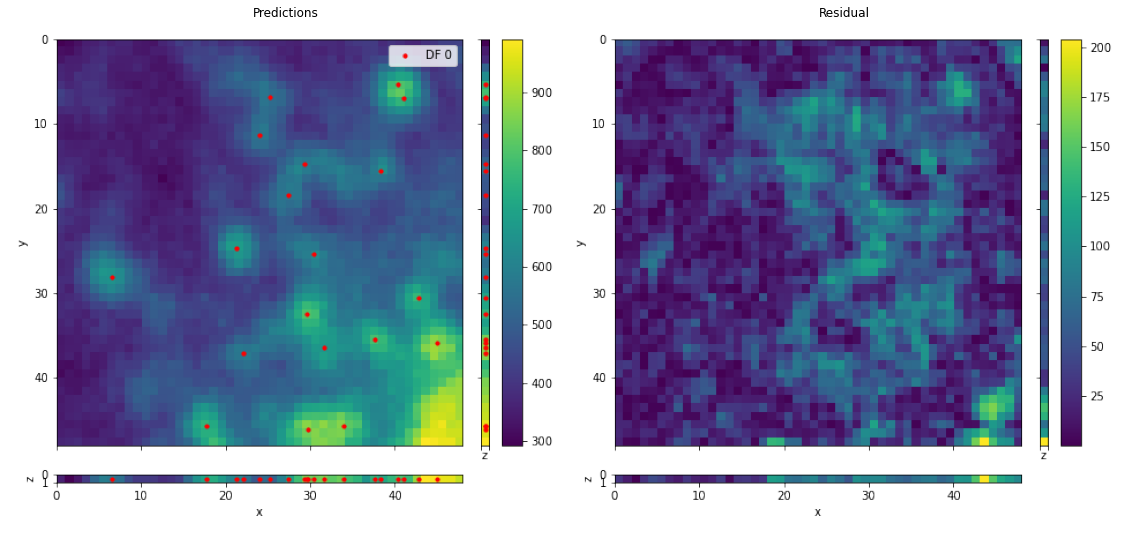

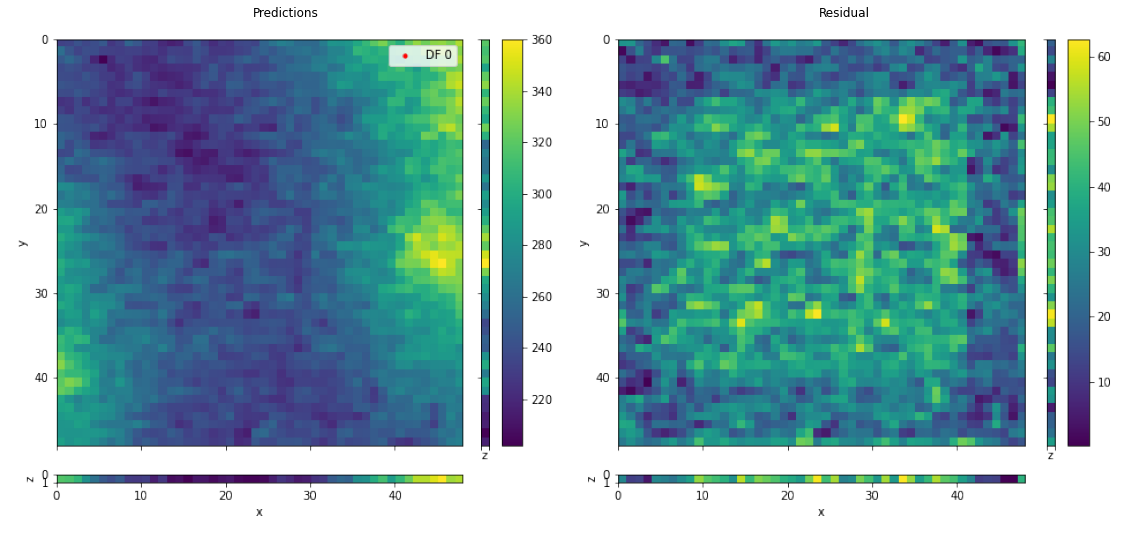

In [1787]:
eval_random_crop(decode_dl, model, post_proc, micro, samples=3)

If you are happy with the results you can run the network on whole volumes to get predictions. Be aware that a model will only produce good results on different recordings if the conditions with regards to PSF and intensity are similar as those used during training.

In [1820]:
# paths = [f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//models/fishcod/MERFISH_starfish/sweep_norm_3a/norm:none/train.yaml',
#          f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//models/fishcod/MERFISH_starfish/sweep_norm_3b/norm:none/train.yaml']

paths = [f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//models/fishcod/MERFISH_starfish/nb_run/MERFISH_starfish_ch0_f4/train.yaml',
         f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//models/fishcod/MERFISH_starfish/nb_run/MERFISH_starfish_ch1_f4/train.yaml']

paths = [f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//models/fishcod/MERFISH_starfish/sweep_bg_1a/scale:0xsmoothing_filter_size:9/train.yaml',
         f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//models/fishcod/MERFISH_starfish/sweep_bg_1b/scale:0xsmoothing_filter_size:9/train.yaml']

# paths = [f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//models/fishcod/MERFISH_starfish/sweep_bg_1b/scale:0xsmoothing_filter_size:5/train.yaml']

In [1821]:
for i,p in enumerate(paths):
    cfg = OmegaConf.load(p)
    model, post_proc, micro, img_3d, decode_dl = load_all(cfg)
#     post_proc.samp_threshold = 0.5
    image_paths = sorted(glob.glob(str(Path(cfg.data_path.image_path).parent)+'/bit*.tiff'))
    inf_df = predict(model, post_proc, image_paths, sm_fish_ch=cfg.data_path.sm_fish_ch, window_size=[None, 128, 128], device='cuda')
    inf_df.to_csv(f'../data/results/MERFISH/exp_3_ch{cfg.data_path.sm_fish_ch}.csv', index=False)

  0%|                                                                         | 0/8 [00:00<?, ?it/s]

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
8 volumes
bit_0.tiff
torch.Size([1, 1, 1, 2048, 2048])


 12%|████████▏                                                        | 1/8 [00:04<00:28,  4.12s/it]

N. emitters:  19994
bit_1.tiff
torch.Size([1, 1, 1, 2048, 2048])
N. emitters:  20597


 25%|████████████████▎                                                | 2/8 [00:07<00:23,  3.92s/it]

bit_2.tiff
torch.Size([1, 1, 1, 2048, 2048])
N. emitters:  21046


 38%|████████████████████████▍                                        | 3/8 [00:11<00:19,  3.84s/it]

bit_3.tiff
torch.Size([1, 1, 1, 2048, 2048])
N. emitters:  19168


 50%|████████████████████████████████▌                                | 4/8 [00:15<00:15,  3.87s/it]

bit_4.tiff
torch.Size([1, 1, 1, 2048, 2048])
N. emitters:  20459


 62%|████████████████████████████████████████▋                        | 5/8 [00:19<00:11,  3.90s/it]

bit_5.tiff
torch.Size([1, 1, 1, 2048, 2048])
N. emitters:  21869


 75%|████████████████████████████████████████████████▊                | 6/8 [00:23<00:07,  3.97s/it]

bit_6.tiff
torch.Size([1, 1, 1, 2048, 2048])
N. emitters:  20164


 88%|████████████████████████████████████████████████████████▉        | 7/8 [00:27<00:03,  3.99s/it]

bit_7.tiff
torch.Size([1, 1, 1, 2048, 2048])
N. emitters:  34214


  0%|                                                                         | 0/8 [00:00<?, ?it/s]

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
8 volumes
bit_0.tiff
torch.Size([1, 1, 1, 2048, 2048])


 12%|████████▏                                                        | 1/8 [00:04<00:31,  4.45s/it]

N. emitters:  23705
bit_1.tiff
torch.Size([1, 1, 1, 2048, 2048])
N. emitters:  17533


 25%|████████████████▎                                                | 2/8 [00:08<00:26,  4.40s/it]

bit_2.tiff
torch.Size([1, 1, 1, 2048, 2048])
N. emitters:  19165


 38%|████████████████████████▍                                        | 3/8 [00:13<00:21,  4.31s/it]

bit_3.tiff
torch.Size([1, 1, 1, 2048, 2048])
N. emitters:  17079


 50%|████████████████████████████████▌                                | 4/8 [00:17<00:16,  4.24s/it]

bit_4.tiff
torch.Size([1, 1, 1, 2048, 2048])
N. emitters:  16728


 62%|████████████████████████████████████████▋                        | 5/8 [00:21<00:12,  4.27s/it]

bit_5.tiff
torch.Size([1, 1, 1, 2048, 2048])
N. emitters:  27550


 75%|████████████████████████████████████████████████▊                | 6/8 [00:26<00:08,  4.37s/it]

bit_6.tiff
torch.Size([1, 1, 1, 2048, 2048])
N. emitters:  25666


 88%|████████████████████████████████████████████████████████▉        | 7/8 [00:30<00:04,  4.35s/it]

bit_7.tiff
torch.Size([1, 1, 1, 2048, 2048])
N. emitters:  17401


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:34<00:00,  4.34s/it]


In [ ]:
from monai.inferers import sliding_window_inference
def predict(model, post_proc, image_paths, sm_fish_ch=0, window_size=[None,128,128], device='cuda'):
    ret = []
    with torch.no_grad():
        for p in tqdm(image_paths):
            print(p.split('/')[-1])
            img = load_tiff_image(p)[sm_fish_ch]
            z, y, x = img.shape[-3:]
            img = img.reshape(-1,z,y,x)
            for i in range(len(img)):
                print(img[i][None,None].shape)
                output = sliding_window_inference(img[i][None,None], window_size, 1, model.to(device), overlap=0.2, sw_device=device, device='cpu', mode='gaussian')
                # output = model.cpu()(img[i][None,None])
                output = model.tensor_to_dict(output)
                ret.append(torch.sigmoid(output['logits']))
                free_mem()
        return ret

In [1867]:
# export
def predict(model, post_proc, image_paths, sm_fish_ch=0, window_size=[None,128,128], device='cuda'):
    ret = []
    with torch.no_grad():
        for p in tqdm(image_paths):
            print(p.split('/')[-1])
            img = load_tiff_image(p)[sm_fish_ch]
            z, y, x = img.shape[-3:]
            img = img.reshape(-1,z,y,x)
            for i in range(len(img)):
                print(img[i][None,None].shape)
                output = sliding_window_inference(img[i][None,None], window_size, 1, model.to(device), overlap=0.2, sw_device=device, device='cpu', mode='gaussian')
                # output = model.cpu()(img[i][None,None])
                output = model.tensor_to_dict(output)
                p_si = sliding_window_inference(output['logits'], window_size, 1, post_proc, overlap=0.2, sw_device=device, device='cpu', mode='gaussian')
                ret.append(p_si)
                free_mem()
        return ret

In [1868]:
arrs = []
for i,p in enumerate(paths):
    cfg = OmegaConf.load(p)
    model, post_proc, micro, img_3d, decode_dl = load_all(cfg)
#     post_proc.samp_threshold = 0.5
    image_paths = sorted(glob.glob(str(Path(cfg.data_path.image_path).parent)+'/bit*.tiff'))
    arrs.append(predict(model, post_proc, image_paths, sm_fish_ch=cfg.data_path.sm_fish_ch, window_size=[None, 128, 128], device='cuda'))

  0%|                                                                         | 0/8 [00:00<?, ?it/s]

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
8 volumes
bit_0.tiff
torch.Size([1, 1, 1, 2048, 2048])


 12%|████████▏                                                        | 1/8 [00:03<00:26,  3.77s/it]

bit_1.tiff
torch.Size([1, 1, 1, 2048, 2048])


 25%|████████████████▎                                                | 2/8 [00:07<00:22,  3.83s/it]

bit_2.tiff
torch.Size([1, 1, 1, 2048, 2048])


 38%|████████████████████████▍                                        | 3/8 [00:11<00:19,  3.95s/it]

bit_3.tiff
torch.Size([1, 1, 1, 2048, 2048])


 50%|████████████████████████████████▌                                | 4/8 [00:15<00:15,  3.94s/it]

bit_4.tiff
torch.Size([1, 1, 1, 2048, 2048])


 62%|████████████████████████████████████████▋                        | 5/8 [00:20<00:12,  4.11s/it]

bit_5.tiff
torch.Size([1, 1, 1, 2048, 2048])


 75%|████████████████████████████████████████████████▊                | 6/8 [00:24<00:08,  4.10s/it]

bit_6.tiff
torch.Size([1, 1, 1, 2048, 2048])


 88%|████████████████████████████████████████████████████████▉        | 7/8 [00:28<00:04,  4.03s/it]

bit_7.tiff
torch.Size([1, 1, 1, 2048, 2048])


  0%|                                                                         | 0/8 [00:00<?, ?it/s]

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
8 volumes
bit_0.tiff
torch.Size([1, 1, 1, 2048, 2048])


 12%|████████▏                                                        | 1/8 [00:04<00:29,  4.21s/it]

bit_1.tiff
torch.Size([1, 1, 1, 2048, 2048])


 25%|████████████████▎                                                | 2/8 [00:08<00:24,  4.07s/it]

bit_2.tiff
torch.Size([1, 1, 1, 2048, 2048])


 38%|████████████████████████▍                                        | 3/8 [00:12<00:21,  4.23s/it]

bit_3.tiff
torch.Size([1, 1, 1, 2048, 2048])


 50%|████████████████████████████████▌                                | 4/8 [00:16<00:15,  3.95s/it]

bit_4.tiff
torch.Size([1, 1, 1, 2048, 2048])


 62%|████████████████████████████████████████▋                        | 5/8 [00:19<00:11,  3.78s/it]

bit_5.tiff
torch.Size([1, 1, 1, 2048, 2048])


 75%|████████████████████████████████████████████████▊                | 6/8 [00:23<00:07,  3.83s/it]

bit_6.tiff
torch.Size([1, 1, 1, 2048, 2048])


 88%|████████████████████████████████████████████████████████▉        | 7/8 [00:28<00:04,  4.23s/it]

bit_7.tiff
torch.Size([1, 1, 1, 2048, 2048])


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:32<00:00,  4.06s/it]


(1250.0, 1750.0)

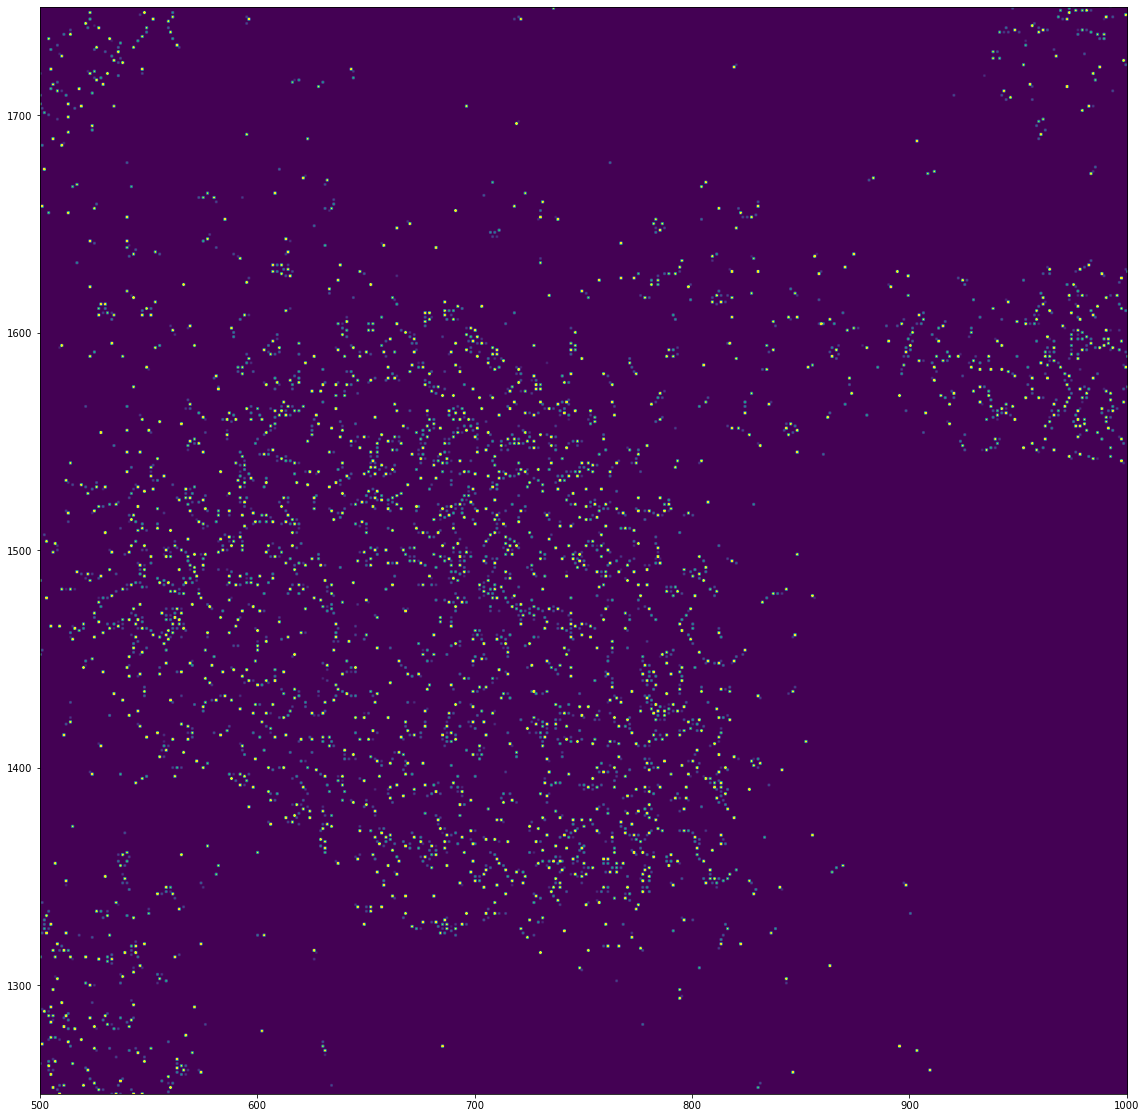

In [1869]:
plt.figure(figsize=(20,20))
plt.imshow(arrs[0][0][0][0,0],vmax=0.5)
plt.xlim(500,1000)
plt.ylim(1250,1750)

In [1870]:
np.save('../data/results/MERFISH/exp_3_pp_arr', np.stack([np.stack(arrs[0])[:,0],np.stack(arrs[1])[:,0]],1)[:,:,0])

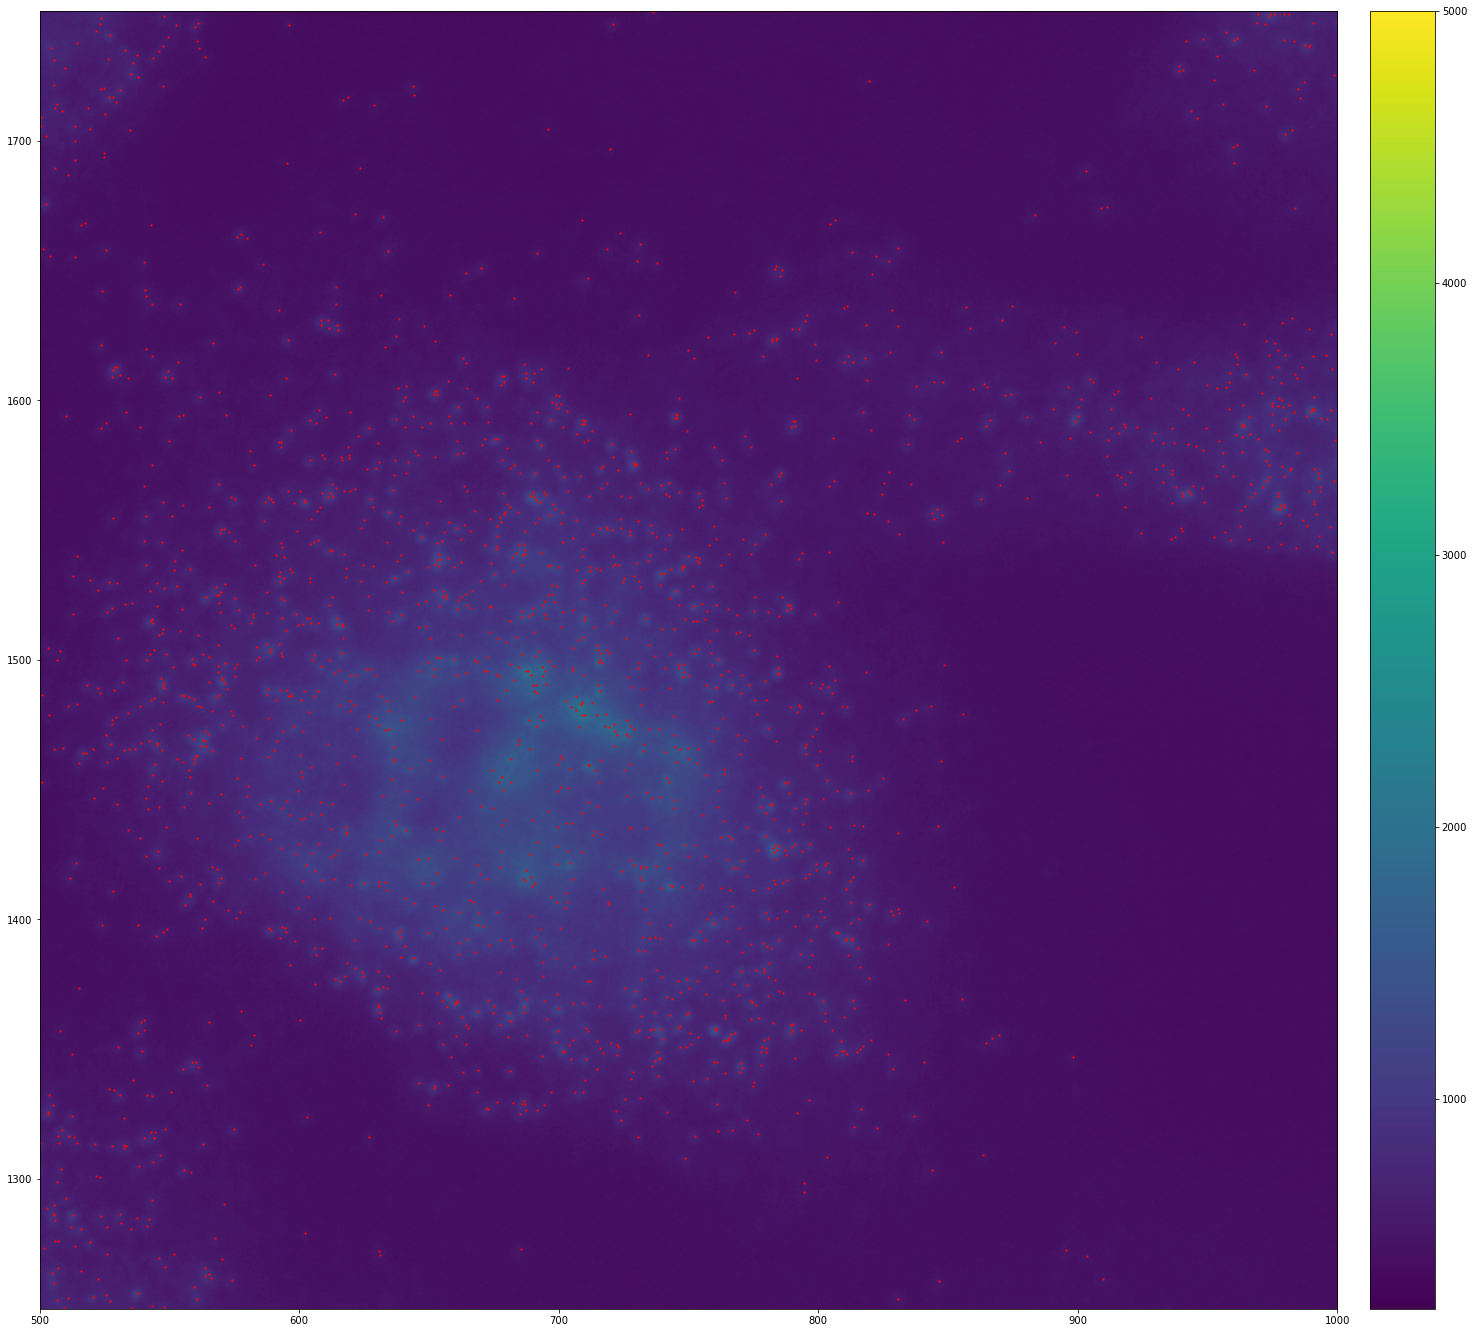

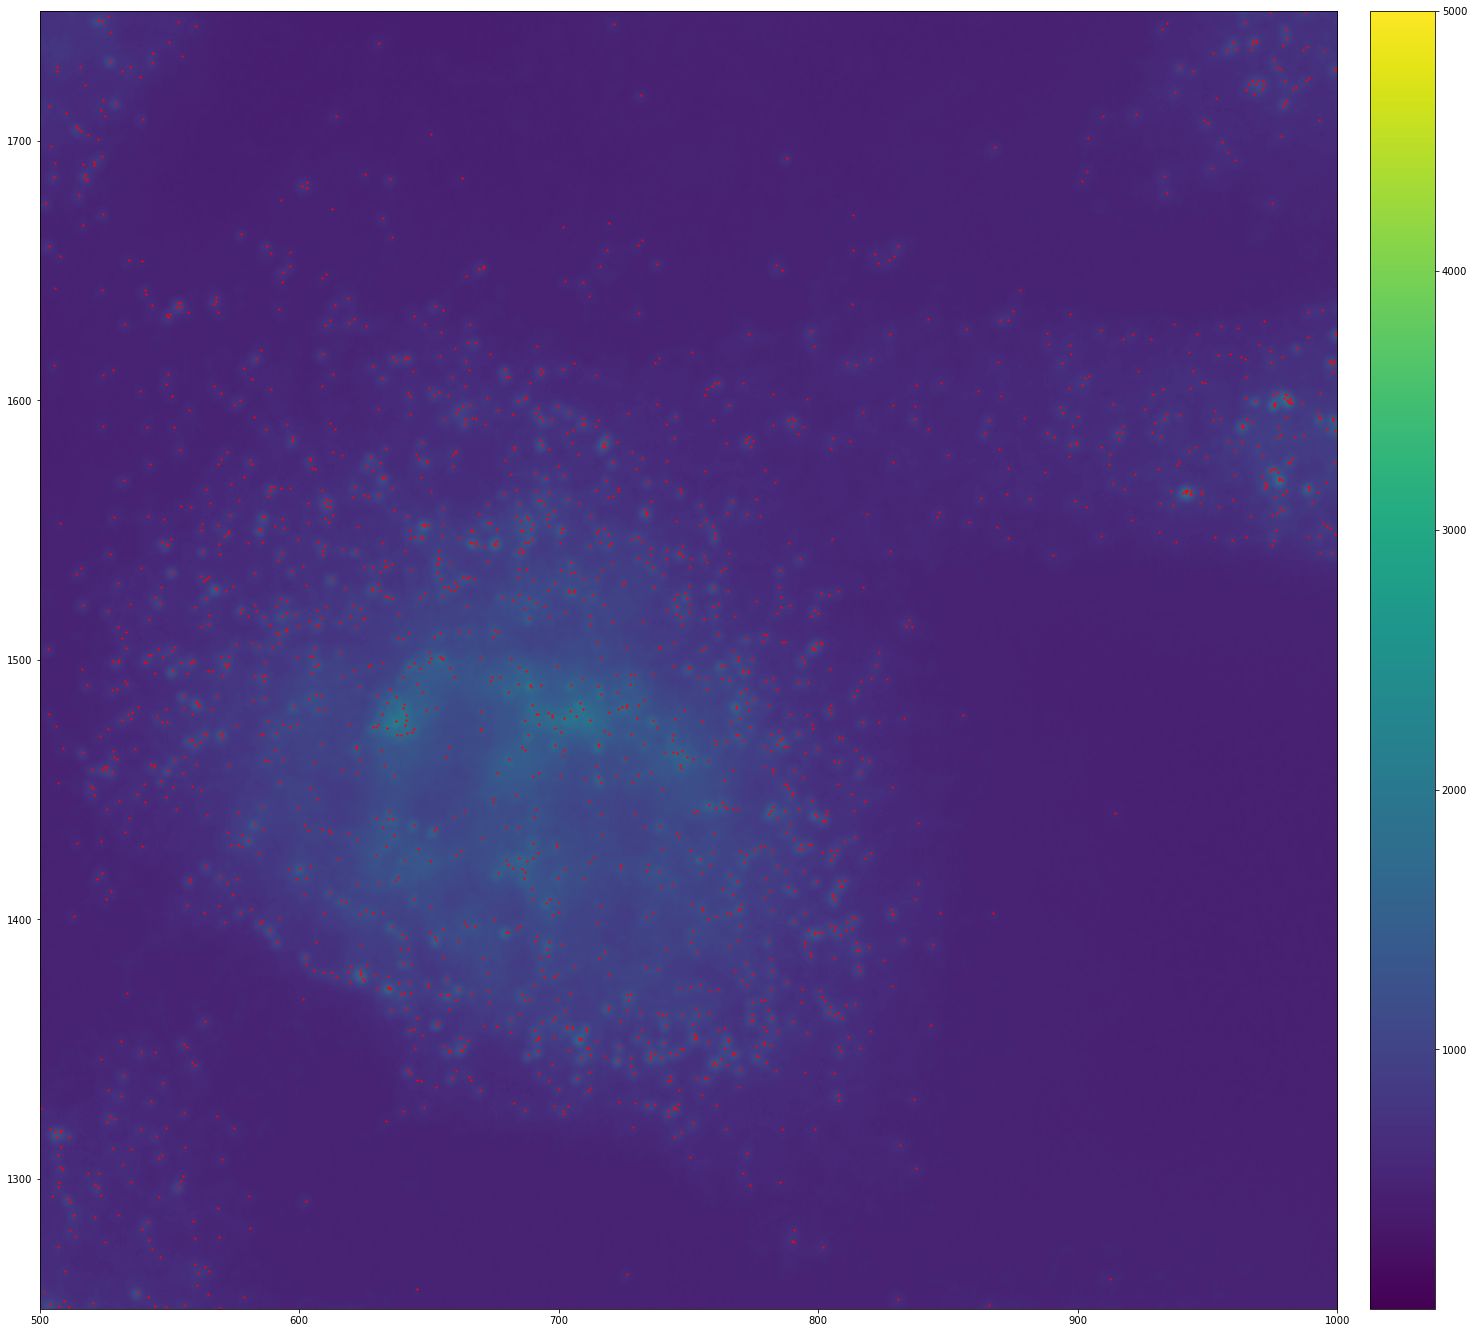

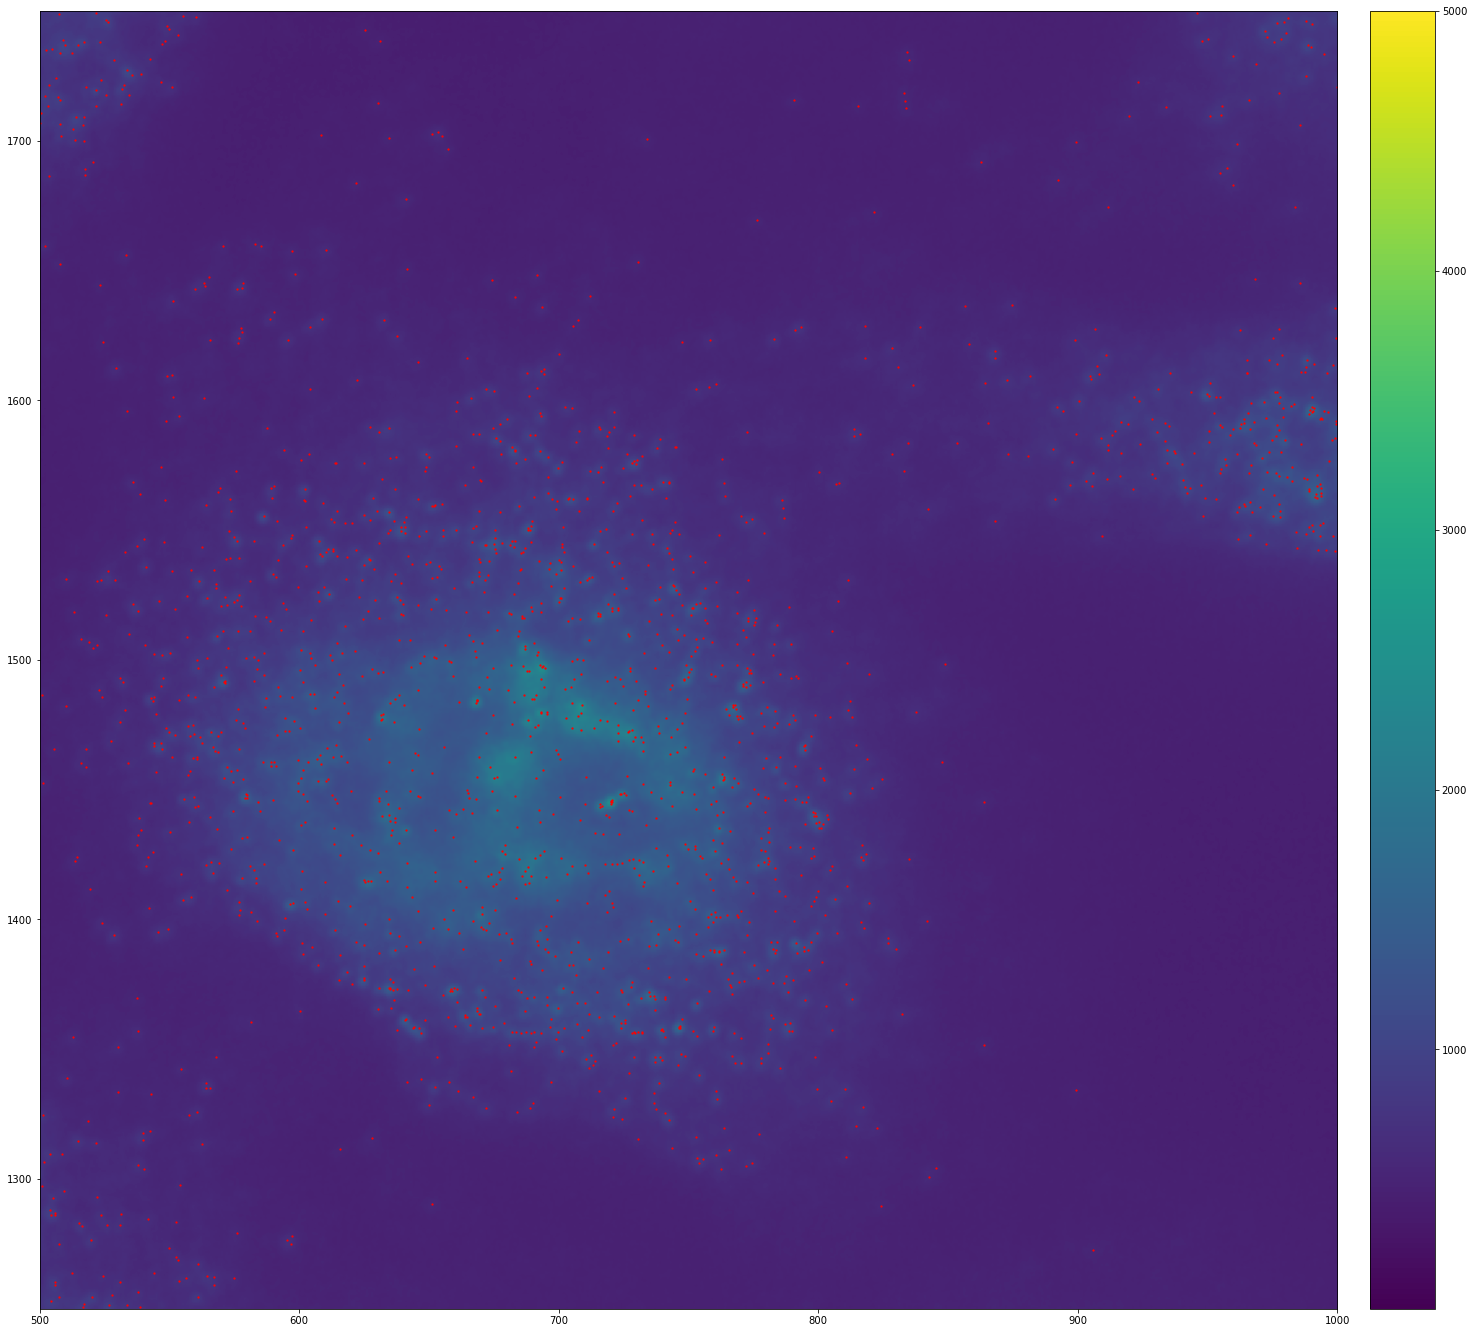

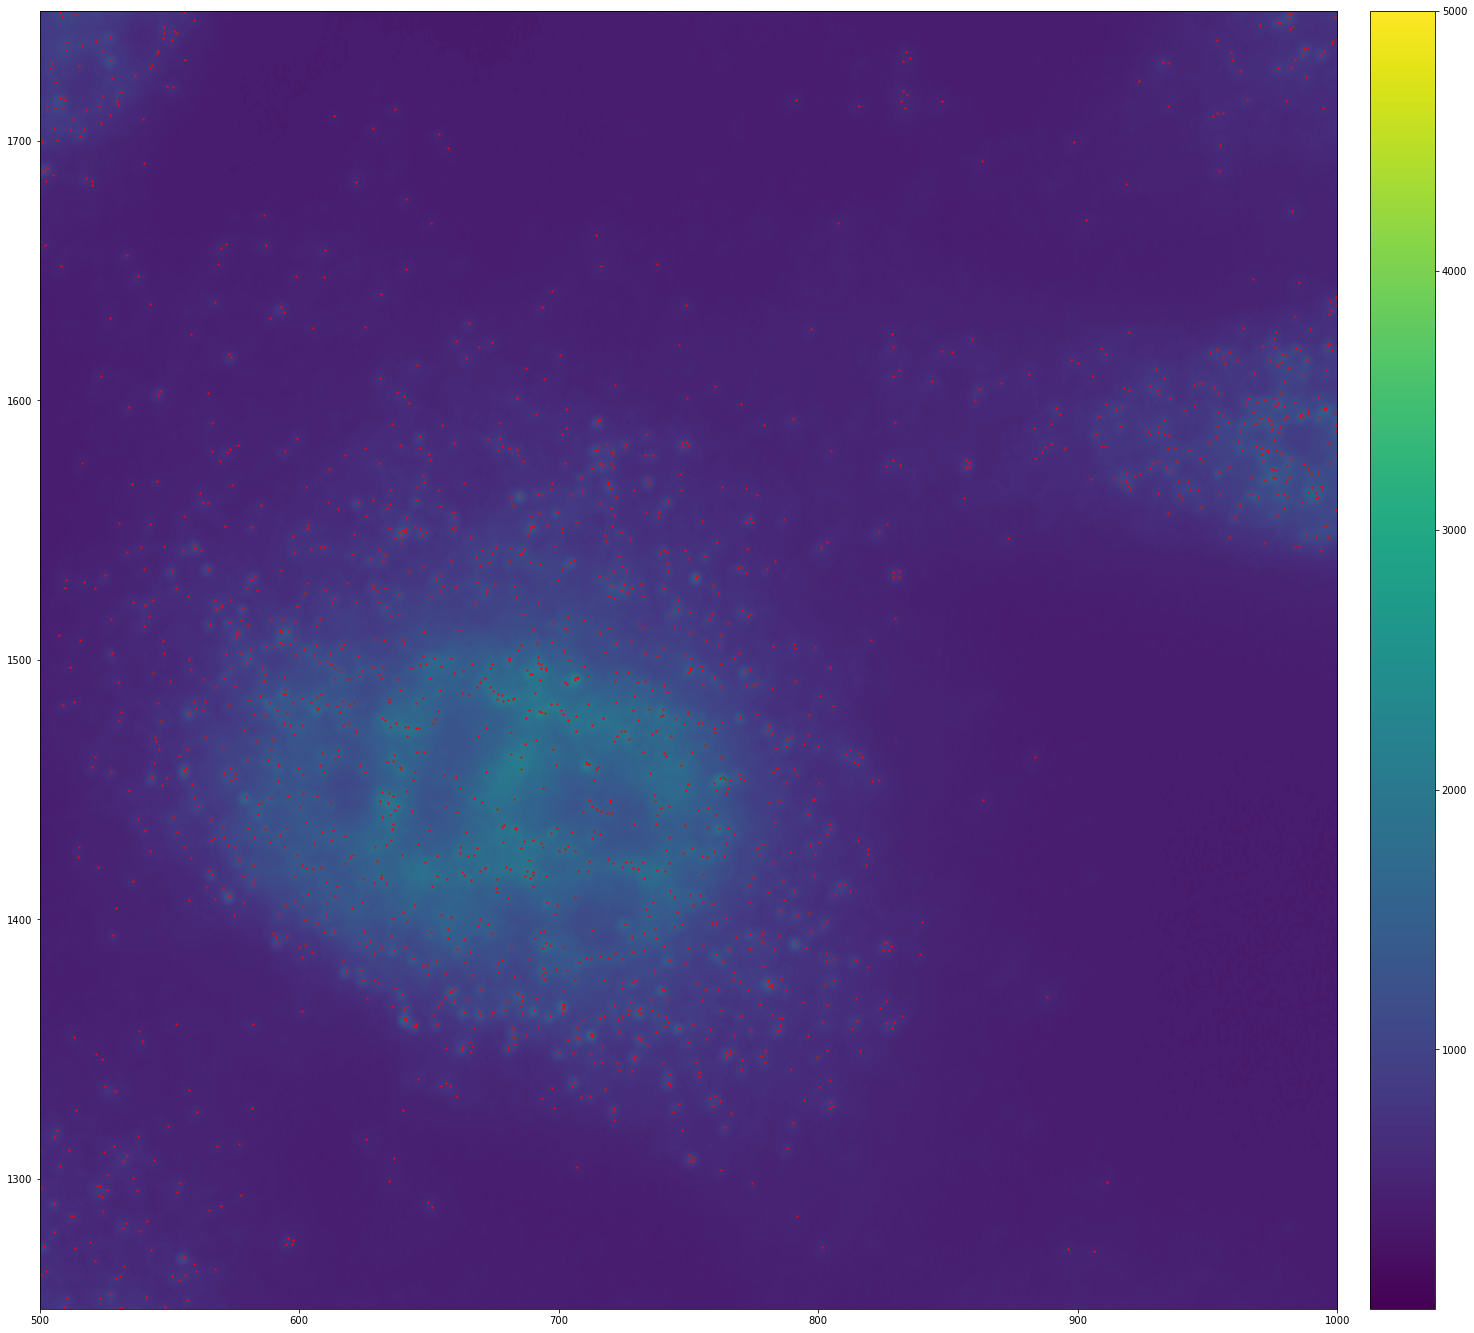

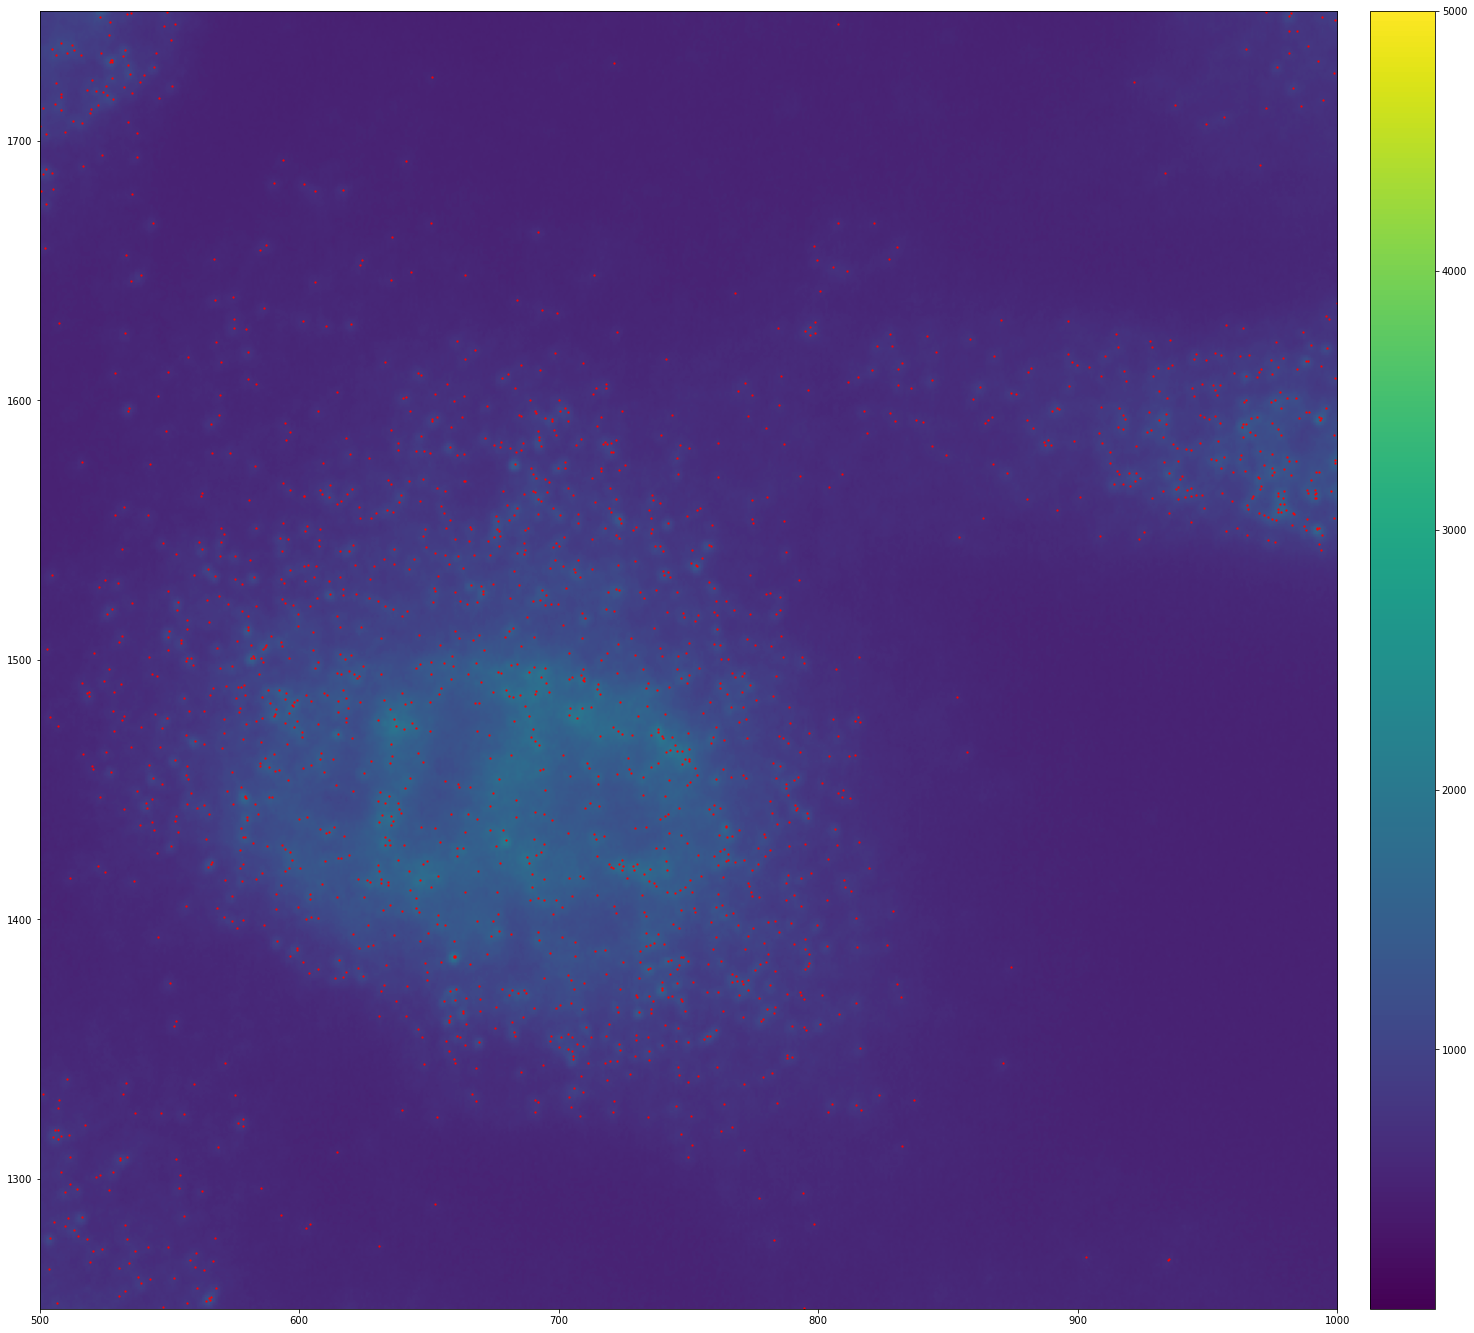

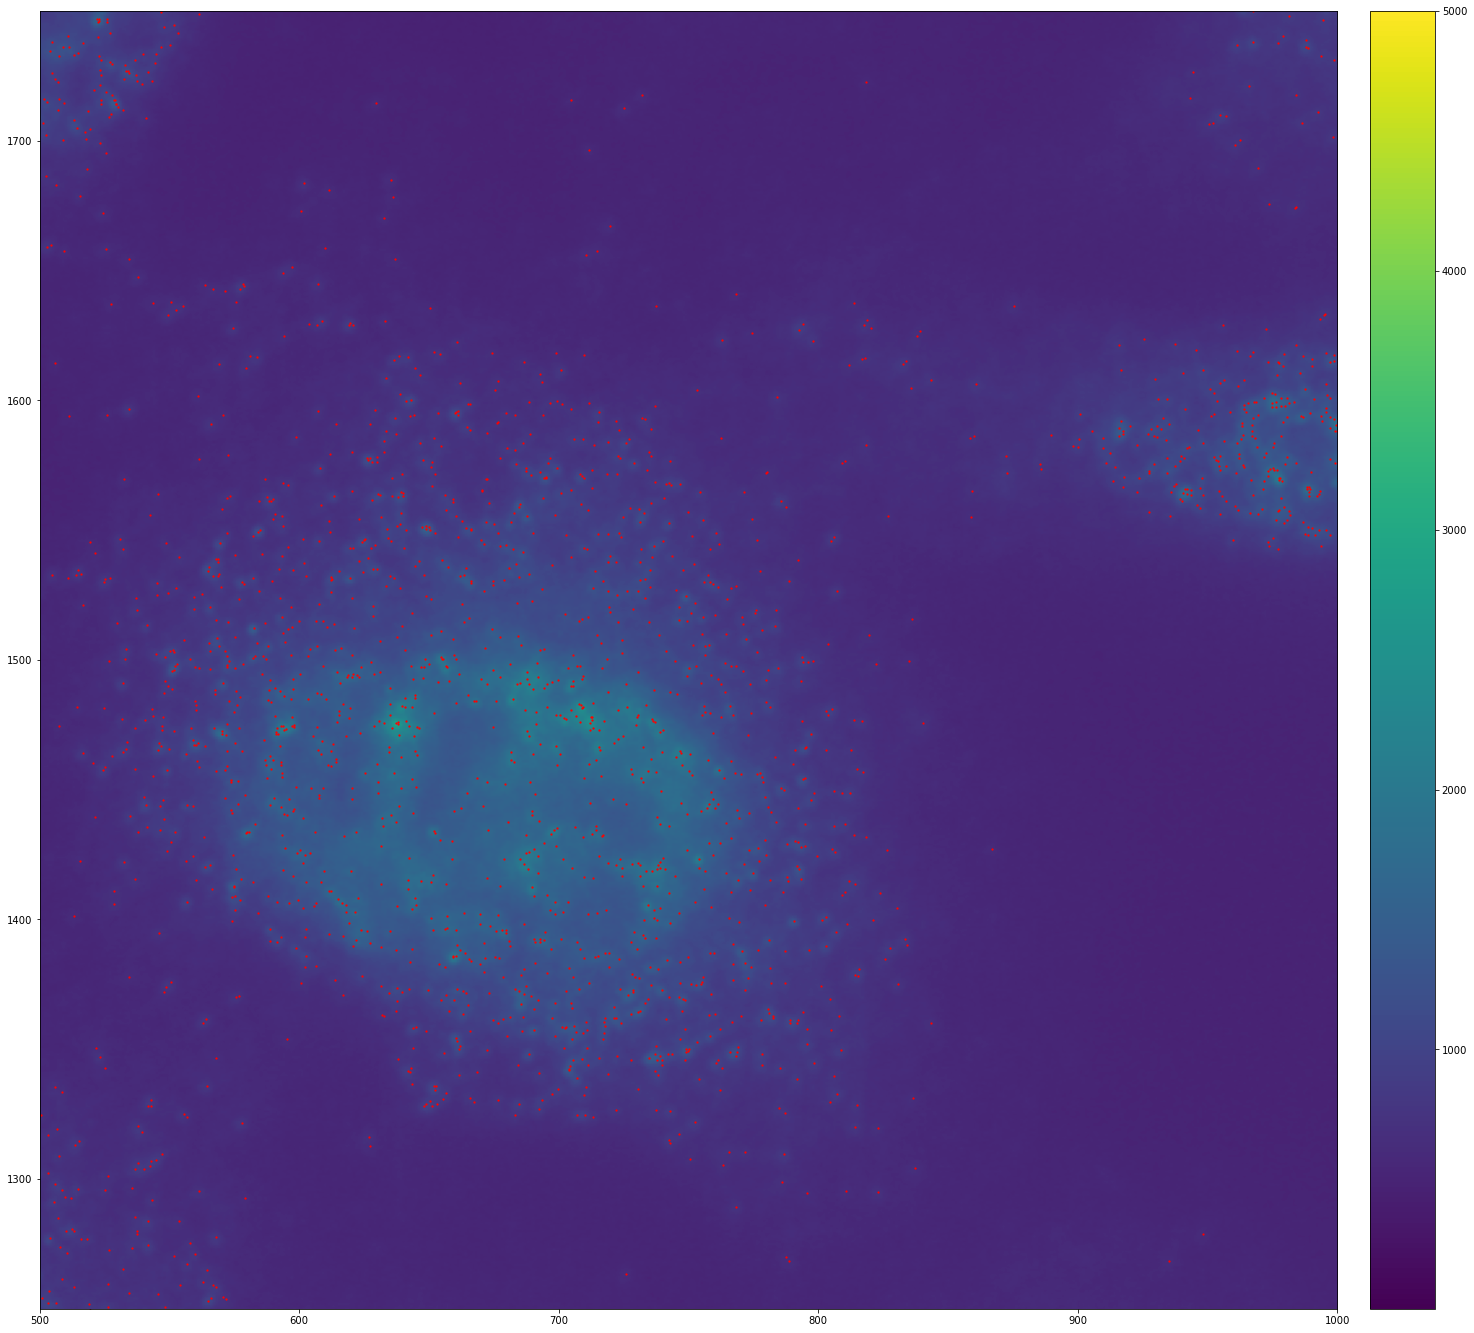

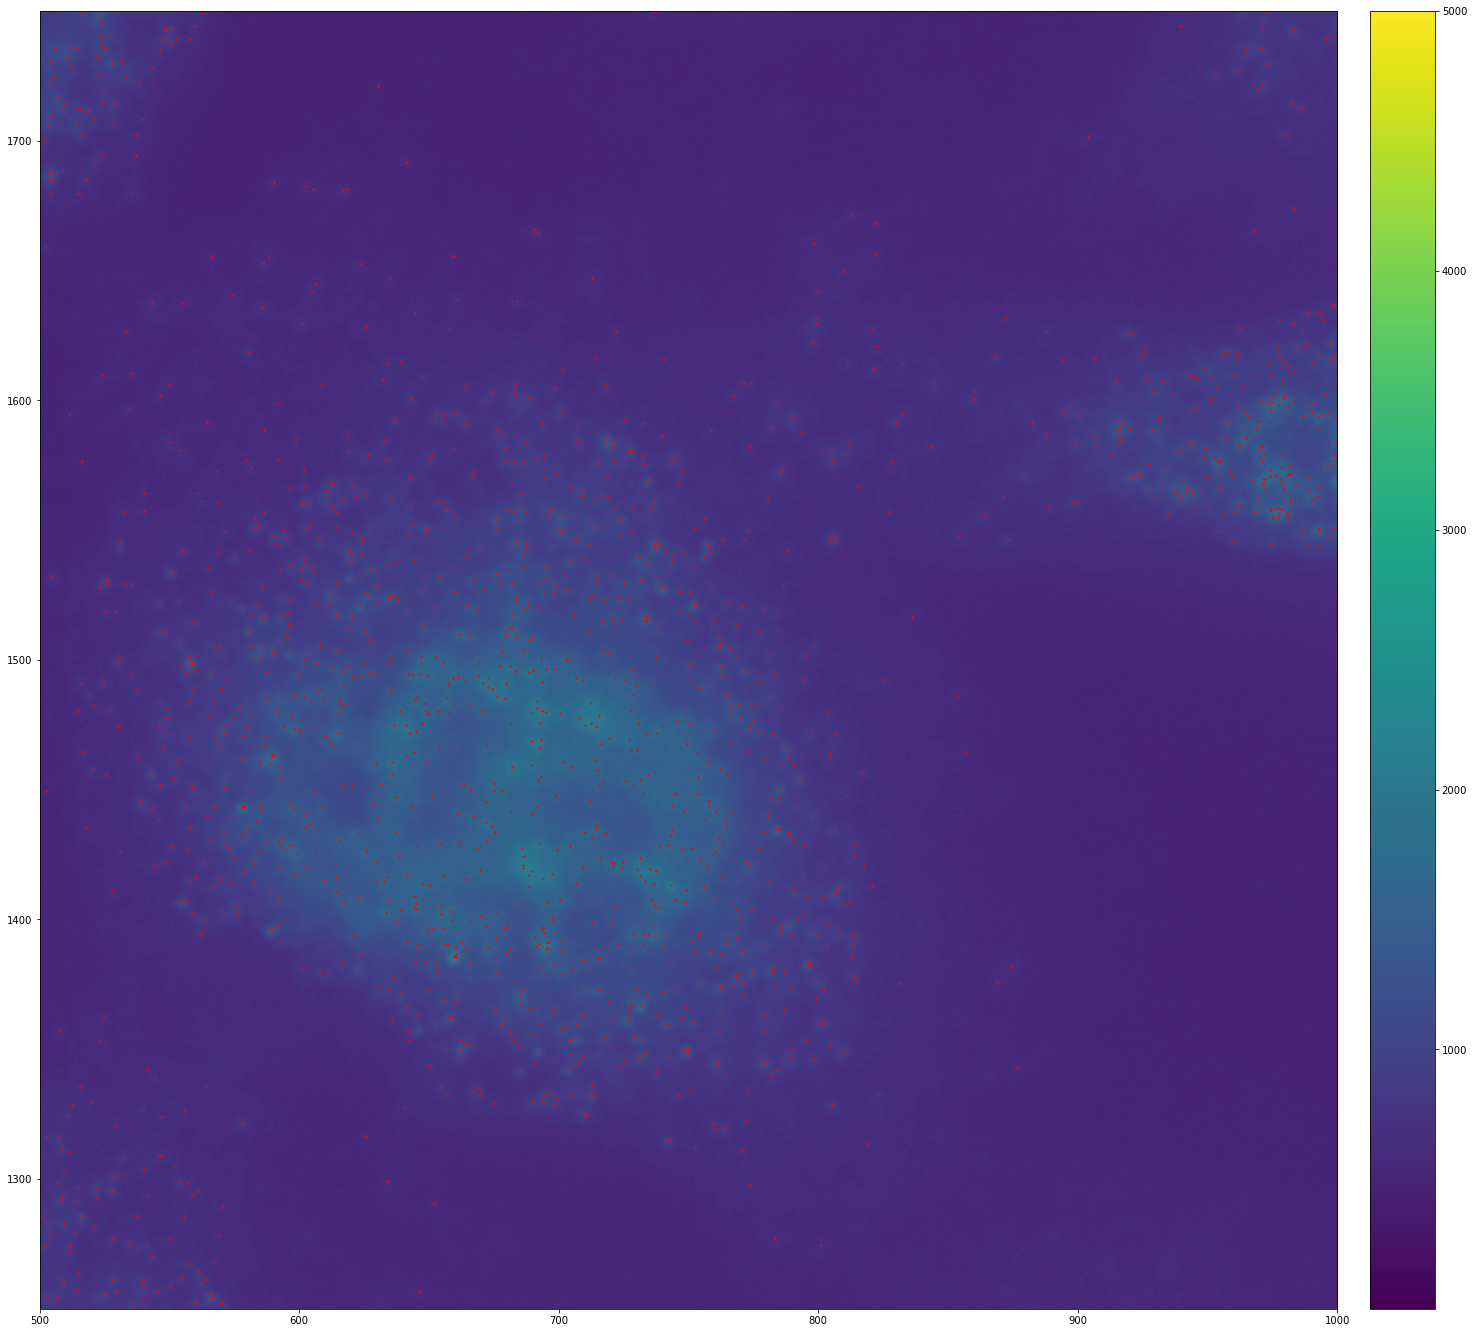

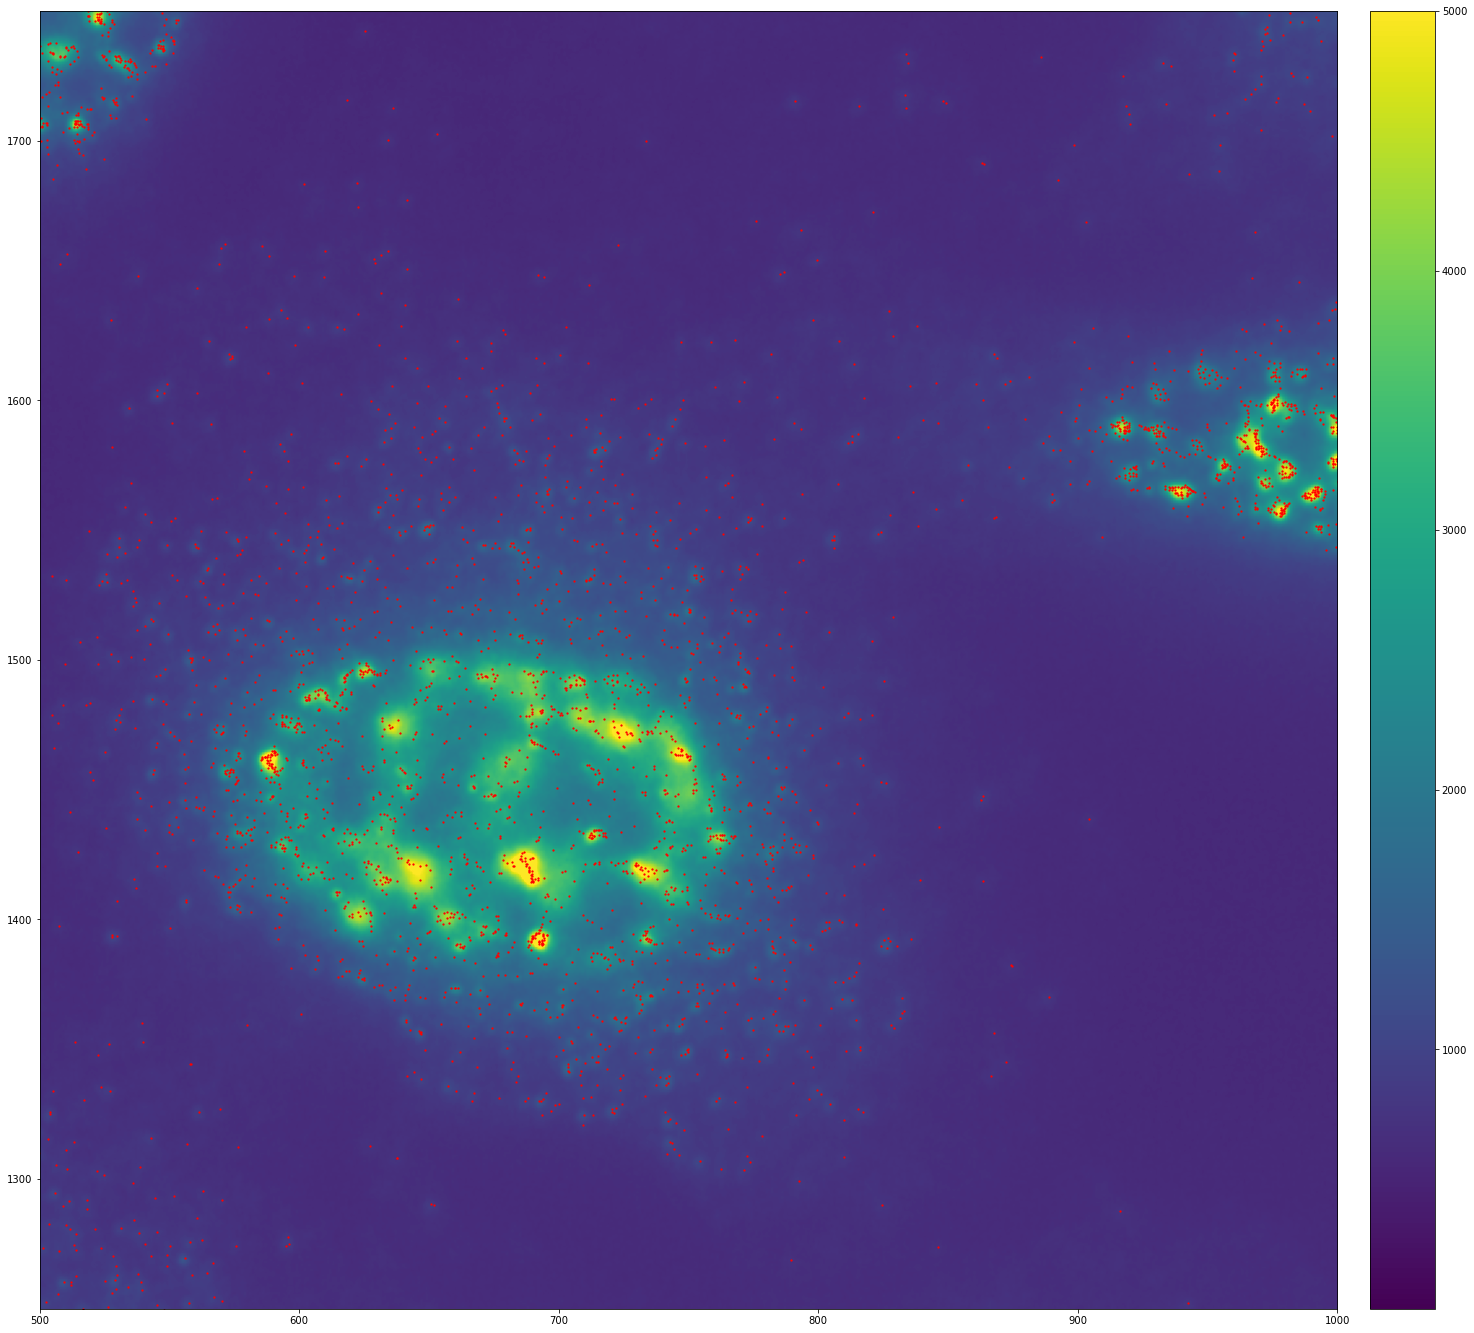

In [1818]:
for i in range(8):

    img = load_tiff_image(image_paths[i])
    preds_px = nm_to_px(inf_df[inf_df['frame_idx']==(i)])
    plt.figure(figsize=(25,25))
    im = plt.imshow(img[cfg.data_path.sm_fish_ch,0], vmax=5000)
    add_colorbar(im)
    plt.xlim(500,1000)
    plt.ylim(1250,1750)

    plt.scatter(preds_px['x'],preds_px['y'], color='red', s=1.5)
    plt.show()

In [1764]:
inf_dfdd

loc_idx  frame_idx              x              y     z      prob  \
0            0          0  106959.679688      11.433807  50.0  0.860915   
1            1          0  108870.609375       5.686301  50.0  0.729370   
2            2          0   62519.097656     138.246796  50.0  0.890993   
3            3          0   78541.421875     121.736732  50.0  0.965898   
4            4          0   83540.351562     100.688316  50.0  0.731164   
...        ...        ...            ...            ...   ...       ...   
66880    66880          7   90643.179688  204780.843750  50.0  1.000000   
66881    66881          7  153674.843750  204778.593750  50.0  0.874982   
66882    66882          7  160482.562500  204784.062500  50.0  0.877933   
66883    66883          7  163398.640625  204782.343750  50.0  0.631391   
66884    66884          7  196023.578125  204782.953125  50.0  0.666884   

            int   int_sig      x_sig      y_sig  z_sig  comb_sig  
0      4.483032  0.549037  23.917063  12.079387  100.0  1.035275  
1      3.570115  0.362590  25.396648  13.117459  100.0  1.040051  
2      4.119069  0.474461  23.785904  24.899483  100.0  1.057627  
3      4.384035  0.542615  27.160391  29.810295  100.0  1.078255  
4      3.870629  0.503859  39.559433  33.758034  100.0  1.127145  
...         ...       ...        ...        ...    ...       ...  
66880  5.643668  0.720595  22.929913  10.705006  100.0  1.031522  
66881  4.270911  0.616791  39.395714  13.293174  100.0  1.082993  
66882  4.102588  0.535403  27.006260  12.489429  100.0  1.043328  
66883  4.020893  0.438042  24.988718  11.176407  100.0  1.036791  
66884  4.375007  0.624716  27.755795  11.354786  100.0  1.043998  

[66885 rows x 12 columns]